In [1]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import cbook
import psutil
import time

# Time evolution with matrix product operators

## Create the MPOs

In [2]:
# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, J):
    """
    Creates the MPO for H0 = sum_i J sigma_i^z sigma_{i+1}^z

    Parameters:
        N (int): Number of qubits
        J: Coefficient of J

    Returns:
        list of np.ndarray: MPO tensors for H0
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 3, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = 0
            tensor[0,1, :, :] = J * sigma_z
            tensor[0,2, :, :] = I
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((3, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = J * sigma_z
            tensor[2,0, :, :] = 0
        else:
            # Middle tensors
            tensor = np.zeros((3, 3, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = sigma_z
            tensor[2,1, :, :] = J * sigma_z
            tensor[2,2, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [3]:
# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x

    Parameters:
        N (int): Number of qubits

    Returns:
        list of np.ndarray: MPO tensors for Hc
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo

In [4]:
def create_I_mpo(N):

    """
    Creates the MPO for the identity

    Parameters:
        N (int): Number of qubits

    Returns:
        list of np.ndarray: MPO tensors for I
    """

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo
        

## Define the functions to operate with MPOs 

In [5]:
def add(mpo1,mpo2):

    """
    Adds two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the sum mpo1+mpo2
    """

    ## Check MPOs have the same number of tensors (live in the same dimension)
    assert len(mpo1) == len(mpo2)

    ## We start by creating an empty list of tensors with adequate dimensions
    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the ending boundary to the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the summed tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the summed central tensors
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo

In [6]:
def prod_scalar(mpo, c):

    """
    Takes the product of an MPO with a scalar

    Parameters:
        mpo: MPO
        c: scalar

    Returns:
        list of np.ndarray: MPO tensors for the product cMPO
    """
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo

In [7]:
def prod(mpo1,mpo2):

    """
    Mulitplies two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the product (mpo1)(mpo2)
    """

    ## Check MPOs have the same number of tensors (live in the same dimension)
    assert len(mpo1) == len(mpo2)

    ## We start by creating an empty list of tensors with adequate dimensions
    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[1]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo

In [8]:
def commutator(mpo1,mpo2):

    """
    Commutator of two MPOs

    Parameters:
        mpo1: first MPO
        mpo2: second MPO

    Returns:
        list of np.ndarray: MPO tensors for the operation [mpo1, mpo2]
    """
    
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))

## From MPO to full matrix

In [9]:
def contract(mpo):

    """
    Contracts an MPO to a dense matrix form

    Parameters:
        mpo: MPO

    Returns:
        matrix representation of the MPO
    """
    
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=np.complex128))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            for j in range(mpo[n].shape[1]):
                mpo_comp += np.kron((mpo_contracted[n])[0,j,:,:],(mpo[n+1])[j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]

## Magnus and Chebyshev approximations for MPO evolution

In [10]:
def Magnus_mpo(mpo_H0,mpo_Hc,u,T,order):

    """
    Computes the Magnus expansion as an MPO.

    Parameters:
        mpo_H0: numpy array, static Hamiltonian as mpo
        mpo_Hc: numpy array, control Hamiltonian as mpo
        u: function u(t) defining time dependence
        T: float, total evolution time

    Returns:
        M: Magnus series as MPO
    """

    ## Magnus series variables (up to order 3)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    ## Numerical computation for the integrals
    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 
    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))
    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    ## Calculating the MPO terms
    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))

    if order==1:
        M = M1

    if order==2:
        M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)
        M = add(M1,M2)

    if order==3:
        M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)
        M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
        M_now = add(M1,M2)
        M = add(M_now,M3)

    return M

In [11]:
def Chebyshev_mpo(mpo,N,order):
    """
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation

    Parameters:
        mpo: Magnus series as an MPO
        N: number of qubits
        order: approximation order of the Chebyshev polynomial

    Returns:
        C: Chebyshev polynomial approximation as MPO
    """

    ## Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)+2*jn(4,1)
    b = 2*jn(1,1)+6*jn(3,1)
    c = 4*jn(2,1)+16*jn(4,1)
    d = 8*jn(3,1)
    e = 16*jn(4,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)

    if order==1:
        C = add(C1,C2)

    if order==2:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C = add(add(C1,C2),C3)

    if order==3:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C4 = prod_scalar(prod(prod(mpo,mpo),mpo),d)
        C = add(add(add(C1,C2),C3),C4)

    if order==4:
        C3 = prod_scalar(prod(mpo,mpo),c)
        C4 = prod_scalar(prod(prod(mpo,mpo),mpo),d)
        C5 = prod_scalar(prod(prod(prod(mpo,mpo),mpo),mpo),e)
        C = add(add(add(add(C1,C2),C3),C4),C5)
    
    return C

## Exact evolution

In [12]:
import qutip.settings
from scipy.sparse import csr_matrix
qutip.settings.auto_tidyup = False


def get_unitary(H0, Hc, u, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
        H0: numpy array, static Hamiltonian
        Hc: numpy array, control Hamiltonian
        u: function u(t) defining time dependence
        T: float, total evolution time
        timesteps: int, number of time steps for integration

    Returns:
        U_T: numpy array, final unitary matrix at time T
    """

    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0, dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    Hc_q = qt.Qobj(Hc,  dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    
    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qdiags([1] * H0.shape[0], 0)
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)
    
    options = {"nsteps": 10000, "method": "bdf"}
    result = qt.sesolve(H, psi0, tlist, options=options)

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T

In [13]:
def err_fidelity(U,V):

    """
    Computes the fidelity error: 1-fidelity

    Parameters:
        U: first matrix
        V: second matrix

    Returns:
        float, infidelity between U and V
    """

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return np.abs(1 - fidelity)

In [14]:
def compare(N,J,T,order1,order2):

    """
    Computes the error between the MPO evolution (with Magnus and Chebyshev approximations) and the "exact" evoltion

    Parameters:
        N: number of qubits
        J: coefficient for J
        T: total time evolution
        order1: approximation order for Magnus expansion
        order2: approximation order for the Chebyshev polynomial

    Returns:
        float, infidelity between resulting unitaries from MPO evolution and exact evolution with dense matrices
    """
    
    mpo1 = create_H0_mpo(N,J)
    mpo2 = create_Hc_mpo(N)
    H0 = contract(mpo1)
    Hc = contract(mpo2)

    ## Define the control function
    def u(t):
        return 1-t+t**2

    U_exact = get_unitary(H0,Hc,u, T)
    Mag = Magnus_mpo(mpo1,mpo2,u, T,order1)
    U_computed = Chebyshev_mpo(Mag,N,order2)

    Err = err_fidelity(U_exact,contract(U_computed))

    return Err

## Plot infidelities for different time evolutions, for Magnus expansion of order 1 and varying order for the Chebyshev approximation

In [18]:
## Define the parameters we need

N = 4
J = 1
T = 1

def u(t):
    return 1-t+t**2  # Example function, replace with your actual one

In [16]:
## Each of the 4 lists represents each order of Chebyshev approximation, 1 to 4. Inside each list there are 3 lists that will enclose the infidelities for the 3 different time evolutions
errs1 = [[],[],[]]
errs2 = [[],[],[]]
errs3 = [[],[],[]]
errs4 = [[],[],[]]

## The total times will be T/N, T/(2N), T/(10N)
times = [1,2,10]

for i in range(3):
    for n in range(2,N+1):
        errs1[i].append(compare(n,J,1/(times[i]*n),1,1))
        errs2[i].append(compare(n,J,1/(times[i]*n),1,2))
        errs3[i].append(compare(n,J,1/(times[i]*n),1,3))
        errs4[i].append(compare(n,J,1/(times[i]*n),1,4))

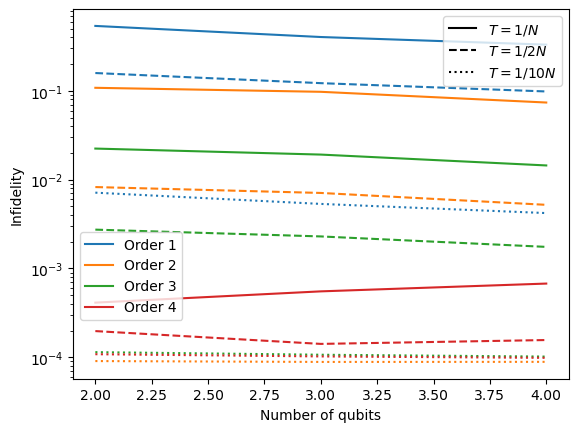

In [17]:
x_values = range(2, N+1)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
linestyles = ['-', '--', ':']
labels_styles = [r"$T=1/N$", r"$T=1/2N$", r"$T=1/10N$"]
labels_colors = ["Order 1", "Order 2", "Order 3", "Order 4"]

plt.figure()

# Plot with different colors and linestyles
for i, (color, errs) in enumerate(zip(colors, [(errs1[0], errs1[1], errs1[2]), (errs2[0], errs2[1], errs2[2]), (errs3[0], errs3[1], errs3[2]), (errs4[0], errs4[1], errs4[2])])):
    for j, (ls, err) in enumerate(zip(linestyles, errs)):
        plt.plot(x_values, err, linestyle=ls, color=color)

# Create legend for linestyles (independent of color)
style_legend = [plt.Line2D([0], [0], linestyle=ls, color='black', label=label) for ls, label in zip(linestyles, labels_styles)]
legend1 = plt.legend(handles=style_legend, loc='upper right')

# Create legend for colors (independent of linestyle)
color_legend = [plt.Line2D([0], [0], linestyle='-', color=color, label=label) for color, label in zip(colors, labels_colors)]
legend2 = plt.legend(handles=color_legend, loc='lower left', bbox_to_anchor=(0, 0.14))

plt.gca().add_artist(legend1)  # Add first legend manually

plt.xlabel('Number of qubits')
plt.ylabel('Infidelity')
plt.yscale("log")
plt.savefig("Times_ising")

plt.show()